In [14]:
import numpy as np
from esda.moran import Moran,Moran_Local
from libpysal.weights import lat2W
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import properscoring as ps
import warnings
from scipy import stats
# from utils.evaluation import plot_histogram,calc_peak,calc_mean
from sklearn.metrics import mean_squared_error
from math import sqrt
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

In [3]:
def calculate_crps(observation, forecasts):
	# forecasts = forecasts[...,None]
	fc = forecasts.copy()
	fc.sort(axis=-1)
	obs = observation
	fc_below = fc < obs[..., None]
	crps = np.zeros_like(obs)

	for i in range(fc.shape[-1]):
		below = fc_below[..., i]
		weight = ((i+1)**2 - i**2) / fc.shape[-1]**2
		crps[below] += weight * (obs[below]-fc[..., i][below])

	for i in range(fc.shape[-1] - 1, -1, -1):
		above = ~fc_below[..., i]
		k = fc.shape[-1] - 1 - i
		weight = ((k+1)**2 - k**2) / fc.shape[-1]**2
		crps[above] += weight * (fc[..., i][above] - obs[above])

	return crps

In [4]:
def plot_histogram(real,pred,binwidth,alpha,type='Mean'):
        """
        This function plots a histogram of the set in question
        """
        # ax = sns.histplot(data=penguins, x="flipper_length_mm", hue="species", element="step")
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.histplot(ax=ax,data=real, stat="density", fill=True,color='#b5a1e2',element='step',alpha=alpha)
        sns.histplot(ax=ax,data=pred, stat="density", fill=True,color='#dc98a8',element='step',alpha=alpha)
        ax.set_xlabel('Mean or Peak rainfall (mm/h)',size=18)
        ax.set_xlabel('%s Rainfall (mm/h)' % type,size=18)
        ax.set_ylabel('Density',size=18)
        plt.legend(labels=['real','pred'],fontsize=24)
        plt.show()
        # plt.savefig('figs/histogram_accumulated_%s.png' % mode)

def calc_peak(array):
        nstorms,_,_ = array.shape
        peaks = np.zeros((nstorms))
        for i in range(nstorms):
                peaks[i] = np.nanmax(array[i])
        return peaks

def calc_mean(array):
        nstorms,_,_ = array.shape
        means = np.zeros((nstorms))
        for i in range(nstorms):
                means[i] = np.nanmean(array[i])
        return means

In [49]:

model = ''
# set mode
mode = 'validation'
print(np.load('/user/home/al18709/work/tc_data_mswep/valid_X.npy').shape)


# load datasets
real = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode))[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0][:,:,:,0]

pred_cnn = np.load('/user/home/al18709/work/cnn/unet_valid.npy')
pred_dsrnngan = np.load('/user/home/al18709/work/dsrnngan_predictions/validation_pred-opt.npy')[0][:,:,:,0]
pred_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0][:,:,:,0]

pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0]
pred_ensemble_gan = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0]
inputs = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_input-opt.npy' % (model,mode))[0][:,:,:,0]


(16253, 10, 10)


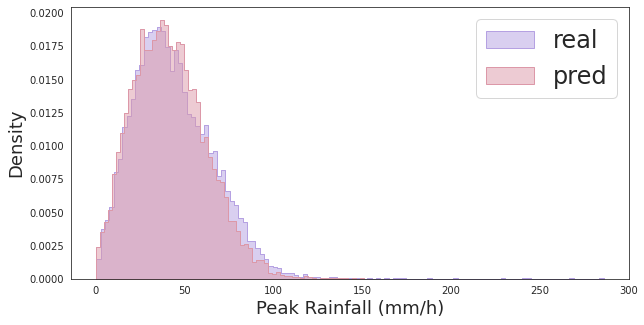

KstestResult(statistic=0.047437396173014235, pvalue=2.493207748019483e-16)
KstestResult(statistic=0.047437396173014235, pvalue=2.493207748019483e-16)


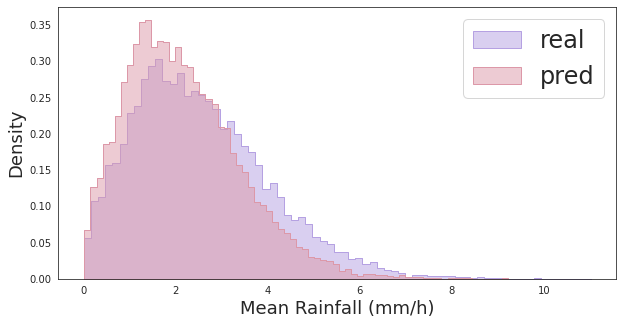

KstestResult(statistic=0.11425582969297976, pvalue=7.265255495667753e-93)
KstestResult(statistic=0.0, pvalue=1.0)
mean real:  2.5540338
mean pred:  2.1603027246414532
std real:  5.023968
std pred:  4.619787596937149


In [45]:
# metric 1
# A standard metric to check how the distributions compare
# TODO: integrate ensemble predictions
# distributions

def distribution(real,pred):
	peak_reals = calc_peak(real)
	peak_preds = calc_peak(pred)
	plot_histogram(peak_reals,peak_preds,5,0.5,type = 'Peak')
	ks = stats.kstest(peak_reals, peak_preds)
	print(ks)
	ks = stats.ks_2samp(peak_reals, peak_preds)
	print(ks)

	mean_reals = calc_mean(real)
	mean_preds = calc_mean(pred)
	plot_histogram(mean_reals,mean_preds,5,0.5)
	ks = stats.kstest(mean_reals, mean_preds)
	print(ks)
	ks = stats.kstest(mean_preds,mean_preds)
	print(ks)


	print('mean real: ',np.mean(real))
	print('mean pred: ', np.mean(pred))
	print('std real: ',np.std(real))
	print('std pred: ',np.std(pred))

distribution(real,pred_dsrnngan)
# ks null hypothesis: two samples drawn from populations with the same distributions
# if p-value is small then you can reject the null hypothesis
# I think we want the p value to be large? or close to 1?

# TODO: could do the same thing for the 90th percentile or just the extreme validation set

In [50]:
# metric 2 
# common probabilistic forecasting score
# CRPS
crps = calculate_crps(real,pred_ensemble_vaegan)
print(crps.shape)
print(np.mean(np.mean(crps,axis=1),axis=1))
print(np.mean(crps))

crps = ps.crps_ensemble(real,pred_ensemble_gan)
print(crps.shape)
print(np.mean(np.mean(crps,axis=1),axis=1))
print('mean crps: ',np.mean(crps))

(16253, 100, 100)
[0.8486595  0.53570825 0.64657134 ... 1.1130773  1.8426758  2.275756  ]
1.0065324
(16253, 100, 100)
[0.50962287 0.39782979 0.4388589  ... 0.78296963 1.34982681 1.77883184]
mean crps:  0.7036095413739814


In [63]:
# metric 3
# standard sanity check, though not usually for stochastic models
# RMSE
nimages,_,_ = real.shape
RMSE = []
# TODO: change cnn shape
print(pred_cnn.shape)
print(pred_vaegan.shape)
print(pred_dsrnngan.shape)
print(real.shape)
for i in range(nimages):
	rmse = sqrt(mean_squared_error(real[i], pred_dsrnngan[i]))
	RMSE.append(rmse)

print(np.mean(RMSE))

(16252, 100, 100)
(16253, 100, 100)
(16253, 100, 100)
(16253, 100, 100)
2.1529438180624028


In [66]:
# metric 4
# metric to look specifically at spatial structure
# power spectra

def log_spectral_distance(img1, img2):
	def power_spectrum_dB(img):
		fx = np.fft.fft2(img)
		fx = fx[:img.shape[0]//2, :img.shape[1]//2]
		px = abs(fx)**2
		return 10 * np.log10(px)

	d = (power_spectrum_dB(img1)-power_spectrum_dB(img2))**2

	d[~np.isfinite(d)] = np.nan
	return np.sqrt(np.nanmean(d))


def log_spectral_distance_batch(batch1, batch2):
	lsd_batch = []
	for i in range(batch1.shape[0]):
		lsd = log_spectral_distance(
				batch1[i, :, :], batch2[i, :, :]
			)
		lsd_batch.append(lsd)
	return np.array(lsd_batch)

lsd = log_spectral_distance_batch(pred_cnn,real)
print(lsd)
print(lsd.mean())

lsd = log_spectral_distance_batch(pred_vaegan,real)
print(lsd)
print(lsd.mean())

lsd = log_spectral_distance_batch(pred_dsrnngan,real)
print(lsd)
print(lsd.mean())

[46.45779379 39.48042665 35.42736349 ... 43.8172778  29.14357512
 38.28375375]
35.755703407115675
[10.6098357  10.64140473 10.15262676 ...  8.25788441  9.38203247
  8.68324385]
11.149678216378184
[ 7.94962544  7.84686947  7.78663985 ...  8.65344338 10.31995622
  7.9870753 ]
9.147888999689584


In [10]:
# metric 6
# Accumulated Rainfall

In [11]:
# metric 7 
# Similarity Score

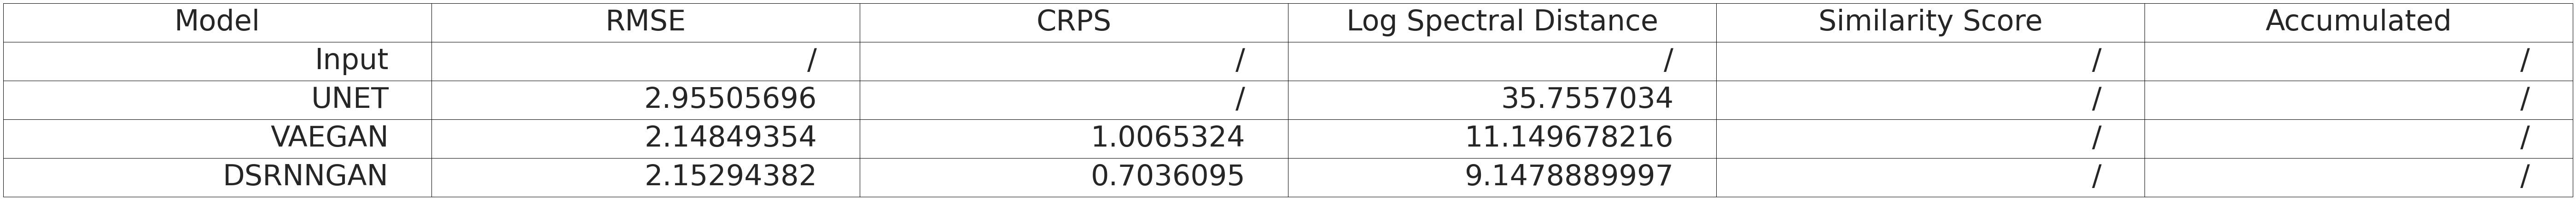

In [68]:
# plot table
fig, ax = plt.subplots(figsize=(10,5))

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


df = pd.DataFrame({
					'Model' : ['Input','UNET','VAEGAN','DSRNNGAN'],
					'RMSE'	: ['/','2.95505696','2.14849354','2.15294382'],
					'CRPS'	: ['/','/','1.0065324','0.7036095'],
					'Log Spectral Distance'	: ['/','35.7557034','11.149678216','9.1478889997'],
					'Similarity Score'	: ['/','/','/','/'],
					'Accumulated'	: ['/','/','/','/']
})
# df = pd.DataFrame(np.random.randn(5, 6), columns=['Model','RMSE','CRPS','LSD','SS','Accumulated'])

table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
# pd.plotting.table(ax,df,loc='top')
table.auto_set_font_size(False)
table.set_fontsize(62)
table.scale(10, 7)

fig.tight_layout()
plt.savefig('table.png')
plt.show()
